# CS/DS 549 Spring 2023 Programming and Model Training Assignment

<a href="https://colab.research.google.com/github/BU-Spark/ml-549-course/blob/main/homeworks/spring24_hw1/sp24_hw1_pt.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.png" alt="Open In Colab"/></a>

## Introduction

The goal of this assignment is to train an image classifier on the CIFAR10
dataset. CIFAR10 is a "toy" dataset in that it only has 10 classes and image
resolution of 32x32x3. There are 50K training images and 10K test images.

Your task is to define a _neural network model_ and _training
hyperparameters_ to reach a __minimum validation accuracy
of 60%__.

The code below is fully functional albeit a simple model with basic hyperparameters.
Update the model and hyperparameters to get the validation accuracy above the
minimum.

The parts of the code you need to change are indicated by the delimiters:

```python
### BEGIN SOLUTION
<your code>
### END SOLUTION
```

Aspects you may want to experiment with are:
1. Deeper and more complex models.
2. Different training optimizers.
3. Hyperparameters like batch_size and epochs.

If you really want get more sophisticated, but not necessary, you can attempt
1. pre-training on a larger dataset and transfer learning
2. additional input image augmentations.

The following are **prohibited**, however:
1. Loading a predefined model.
2. Using a pre-trained model.

You can run this notebook locally on your computer, on SCC or on Google Colab,
with the proper setup.

In [1]:
# The pip install command below is ensure install in Google Colab

In [2]:
pip install torchinfo

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from torchinfo import summary

import matplotlib.pyplot as plt

## Load the Dataset

In [4]:
# Load the CIFAR-10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

### BEGIN SOLUTION
batch_size = 5
### END SOLUTION

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Let's look at some statistics on the training and test set.

In [5]:
print(f"The size of the training set is {len(trainset)} images")
print(f"The size of the test set is {len(testset)} images")

The size of the training set is 50000 images
The size of the test set is 10000 images


Let's look at the loaders.

In [6]:
print("The size of trainloader is ", len(trainloader))
print("The size of testloader is ", len(testloader))

The size of trainloader is  10000
The size of testloader is  2000


### Question: Why is trainloader and testloader smaller than trainset and testset?

We set a number for the batch size, which indicates how many training samples should be used in the iteration. Initially, this number was set to 4, so that means that the loaders would only use a quarter of the original datasets.

## Define the Model

In [7]:
# Define the model architecture
class Net(nn.Module):
    def __init__(self):
        """Initialize the neural network layers we want to use in our model's
        forward pass."""
        super(Net, self).__init__()

        ### BEGIN SOLUTION
        self.conv1 = nn.Conv2d(3, 8, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(8 * 15 * 15, 120)
        self.fc2 = nn.Linear(120, 10)    # we have to end with 10 outputs because we have 10 classes
        ### END SOLUTION

    def forward(self, x):
        ### BEGIN SOLUTION
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(-1, 8 * 15 * 15)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        ### END SOLUTION
        return x

In [8]:
# Initialize the model
net = Net()
print(net)

print(summary(net, input_size=(batch_size, 3, 32, 32)))


Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1800, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)
Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [5, 10]                   --
├─Conv2d: 1-1                            [5, 8, 30, 30]            224
├─MaxPool2d: 1-2                         [5, 8, 15, 15]            --
├─Linear: 1-3                            [5, 120]                  216,120
├─Linear: 1-4                            [5, 10]                   1,210
Total params: 217,554
Trainable params: 217,554
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 2.09
Input size (MB): 0.06
Forward/backward pass size (MB): 0.29
Params size (MB): 0.87
Estimated Total Size (MB): 1.22


In [9]:
# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()

### BEGIN SOLUTION
optimizer = optim.SGD(net.parameters(), lr=0.0085)
### END SOLUTION

## Train the Model

In [10]:
import time

# Initialize a list to hold the losses
losses = []

# Calculate number of batches to process to report 10 times per epoch
len_trainloader = len(trainloader)
report_every = len_trainloader // 10

### BEGIN SOLUTION
epochs = 6
### END SOLUTION

# Train the network
for epoch in range(epochs):  # loop over the dataset multiple times

    start_time = time.time()

    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # record the loss
        # losses.append(loss.item())
        
        # print statistics
        running_loss += loss.item()
        if i % report_every == report_every - 1:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / report_every))

            losses.append(running_loss / report_every)
            running_loss = 0.0

    end_time = time.time()
    print('Epoch {} took {} seconds'.format(epoch+1, end_time - start_time))

print('Finished Training with training loss of ', losses[-1])

[1,  1000] loss: 2.086
[1,  2000] loss: 1.867
[1,  3000] loss: 1.722
[1,  4000] loss: 1.612
[1,  5000] loss: 1.539
[1,  6000] loss: 1.493
[1,  7000] loss: 1.458
[1,  8000] loss: 1.434
[1,  9000] loss: 1.372
[1, 10000] loss: 1.372
Epoch 1 took 24.02816915512085 seconds
[2,  1000] loss: 1.300
[2,  2000] loss: 1.276
[2,  3000] loss: 1.297
[2,  4000] loss: 1.243
[2,  5000] loss: 1.280
[2,  6000] loss: 1.243
[2,  7000] loss: 1.241
[2,  8000] loss: 1.209
[2,  9000] loss: 1.231
[2, 10000] loss: 1.189
Epoch 2 took 23.40440583229065 seconds
[3,  1000] loss: 1.122
[3,  2000] loss: 1.113
[3,  3000] loss: 1.110
[3,  4000] loss: 1.116
[3,  5000] loss: 1.135
[3,  6000] loss: 1.138
[3,  7000] loss: 1.114
[3,  8000] loss: 1.102
[3,  9000] loss: 1.084
[3, 10000] loss: 1.101
Epoch 3 took 23.543331623077393 seconds
[4,  1000] loss: 0.989
[4,  2000] loss: 1.007
[4,  3000] loss: 1.023
[4,  4000] loss: 1.010
[4,  5000] loss: 1.025
[4,  6000] loss: 0.999
[4,  7000] loss: 1.003
[4,  8000] loss: 1.032
[4,  900

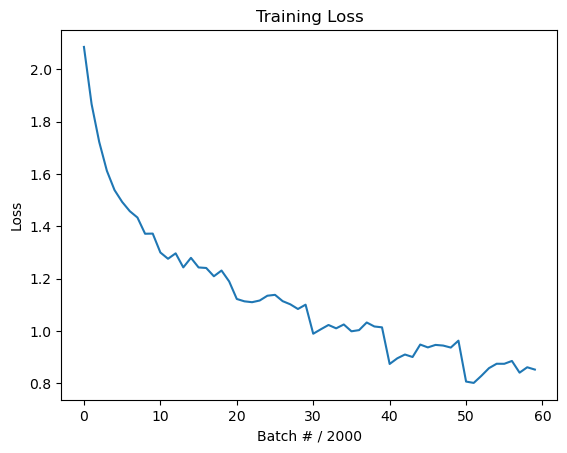

In [11]:
# Plot the training loss
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Batch # / 2000')
plt.ylabel('Loss')
plt.show()

In [12]:
# Evaluate accuracy on the training data
correct = 0
total = 0
train_loss = 0

with torch.no_grad():
    for data in trainloader:
        images, labels = data
        
        outputs = net(images)
        
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total * 100

# Calculate average test loss
avg_train_loss = train_loss / len(trainloader)

print('Accuracy of the network on the training images: %d %%' % (accuracy))
print('Average training loss: %.3f' % (avg_train_loss))

Accuracy of the network on the training images: 75 %
Average training loss: 0.699


## Evaluate the Model

In [13]:
# We'll set the baseline accuracy we want for this exercise.
baseline_accuracy = 60.0

In [14]:
# Evaluate the network on the test data
correct = 0
total = 0
test_loss = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        
        outputs = net(images)
        
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total * 100

# Calculate average test loss
avg_test_loss = test_loss / len(testloader)

print('Accuracy of the network on the 10000 test images: %d %%' % (accuracy))
print('Average test loss: %.3f' % (avg_test_loss))

Accuracy of the network on the 10000 test images: 61 %
Average test loss: 1.123


### Let's see how you did

In [15]:
print('And did you beat the baseline accuracy of ', baseline_accuracy, '?')

if accuracy > baseline_accuracy:
    print('Yes!!! You beat the baseline accuracy!')
else:
    print('Awww! Try again! You can do it!')

# We put an assert here to raise an error if the accuracy is not greater than the baseline accuracy
assert accuracy > baseline_accuracy, 'Accuracy did not beat baseline accuracy of {}'.format(baseline_accuracy)

And did you beat the baseline accuracy of  60.0 ?
Yes!!! You beat the baseline accuracy!


## Model Evaluation Questions

### Question: What was the accuracy of the model as initially defined in the assginment?

The accuracy of the model as initially defined in the assignment was 45%.

### Question: Try running the same model and training hyperparameters multiple times. Does the loss curve and final accuracy differ between runs? Why?

The loss curves and final accuracies differ slightly when the same model is run with the same training hyperparameters. This is because the training and test sets in the initialization of the code is randomized/shuffled every time, so the loss curves and accuracies will change with the changes in the data.

## Record Your Experiments Here

It is helpful if you track your experiments so you can see what you changed and how it impacted accuracy.

### Experiment Template (Copy and Edit)

**Model Definition:**
```python
<model definition here if changed>
```

**Hyperparameters:**
```python
batch size: 3
epochs: 5
optimizer: no change
learning rate: 0.001
momentum: no change
```
Training Loss: 1.178   <br>
Training Accuracy: 58%<br>

Test Loss: 1.263   <br>
**Test Accuracy: 54%**

### Experiment Template (Copy and Edit)

**Model Definition:**
```python
<model definition here if changed>
```

**Hyperparameters:**
```python
batch size: 3
epochs: 5
optimizer: no change
learning rate: 0.01
momentum: no change
```
Training Loss: 0.782   <br>
Training Accuracy: 72%<br>

Test Loss: 1.223   <br>
**Test Accuracy: 59%**

### Experiment Template (Copy and Edit)

**Model Definition:**
```python
<model definition here if changed>
```

**Hyperparameters:**
```python
batch size: 3
epochs: 7
optimizer: no change
learning rate: 0.01
momentum: no change
```
Training Loss: 0.644   <br>
Training Accuracy: 77%<br>

Test Loss: 1.302   <br>
**Test Accuracy: 58%**

### Experiment Template (Copy and Edit)

**Model Definition:**
```python
<model definition here if changed>
```

**Hyperparameters:**
```python
batch size: 3
epochs: 6
optimizer: no change
learning rate: 0.05
momentum: no change
```
Training Loss: 0.051   <br>
Training Accuracy: 64%<br>

Test Loss: 1.788   <br>
**Test Accuracy: 47%**

### Experiment Template (Copy and Edit)

**Model Definition:**
```python
<model definition here if changed>
```

**Hyperparameters:**
```python
batch size: 3
epochs: 6
optimizer: no change
learning rate: 0.007
momentum: no change
```
Training Loss: 0.803   <br>
Training Accuracy: 71%<br>

Test Loss: 1.248   <br>
**Test Accuracy: 58%**

### Experiment Template (Copy and Edit)

**Model Definition:**
```python
<model definition here if changed>
```

**Hyperparameters:**
```python
batch size: 3
epochs: 7
optimizer: no change
learning rate: 0.012
momentum: no change
```
Training Loss: 0.665   <br>
Training Accuracy: 76%<br>

Test Loss: 1.351   <br>
**Test Accuracy: 57%**

### Experiment Template (Copy and Edit)

**Model Definition:**
```python
<model definition here if changed>
```

**Hyperparameters:**
```python
batch size: 2
epochs: 6
optimizer: no change
learning rate: 0.01
momentum: no change
```
Training Loss: 0.769   <br>
Training Accuracy: 72%<br>

Test Loss: 1.342   <br>
**Test Accuracy: 56%**

### Experiment Template (Copy and Edit)

**Model Definition:**
```python
<model definition here if changed>
```

**Hyperparameters:**
```python
batch size: 2
epochs: 8
optimizer: no change
learning rate: 0.01
momentum: no change
```
Training Loss: 0.711   <br>
Training Accuracy: 74%<br>

Test Loss: 1.442   <br>
**Test Accuracy: 56%**

### Experiment Template (Copy and Edit)

**Model Definition:**
```python
<model definition here if changed>
```

**Hyperparameters:**
```python
batch size: 4
epochs: 8
optimizer: no change
learning rate: 0.01
momentum: no change
```
Training Loss: 0.524   <br>
Training Accuracy: 81%<br>

Test Loss: 1.491   <br>
**Test Accuracy: 58%**

### Experiment Template (Copy and Edit)

**Model Definition:**
```python
<model definition here if changed>
```

**Hyperparameters:**
```python
batch size: 4
epochs: 6
optimizer: no change
learning rate: 0.01
momentum: 0.9
```
Training Loss: 1.664   <br>
Training Accuracy: 42%<br>

Test Loss: 1.988   <br>
**Test Accuracy: 33%**

### Experiment Template (Copy and Edit)

**Model Definition:**
```python
<model definition here if changed>
```

**Hyperparameters:**
```python
batch size: 4
epochs: 8
optimizer: no change
learning rate: 0.01
momentum: 0.001
```
Training Loss: 0.619   <br>
Training Accuracy: 78%<br>

Test Loss: 1.340   <br>
**Test Accuracy: 58%**

### Experiment Template (Copy and Edit)

**Model Definition:**
```python
<model definition here if changed>
```

**Hyperparameters:**
```python
batch size: 3
epochs: 8
optimizer: no change
learning rate: 0.01
momentum: 0
```
Training Loss: 0.619   <br>
Training Accuracy: 78%<br>

Test Loss: 1.340   <br>
**Test Accuracy: 58%**